In [ ]:
# 必要なライブラリのインストール
!pip install pandas statsmodels scikit-learn matplotlib seaborn causalml pyreadstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: Cython
    Found existing installati

In [ ]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from causalml.match import NearestNeighborMatch
from causalml.propensity import compute_propensity_score
# from causalml.weights import compute_ipw_weights
from sklearn.preprocessing import StandardScaler

In [ ]:
# データチェック関数の定義
def data_check(df, name="DataFrame"):
    print(f"【{name}の形状】: {df.shape}\n")
    print(f"【{name}の先頭行】: ")
    print(df.head(5), "\n")

In [ ]:
# データの読み込み
nswdw_url = "https://users.nber.org/~rdehejia/data/nsw_dw.dta"
cps1_url = "https://users.nber.org/~rdehejia/data/cps_controls.dta"
cps3_url = "https://users.nber.org/~rdehejia/data/cps_controls3.dta"

# read_stataを使用してデータを読み込む
nswdw_data = pd.read_stata(nswdw_url)
cps1_data = pd.read_stata(cps1_url)
cps3_data = pd.read_stata(cps3_url)

In [ ]:
# NSWデータから介入グループを抽出し、cps1およびcps3に追加
cps1_nsw_data = pd.concat([nswdw_data[nswdw_data['treat'] == 1], cps1_data], ignore_index=True)
cps3_nsw_data = pd.concat([nswdw_data[nswdw_data['treat'] == 1], cps3_data], ignore_index=True)

# データチェック
data_check(cps1_nsw_data, "cps1_nsw_data")
data_check(cps3_nsw_data, "cps3_nsw_data")

【cps1_nsw_dataの形状】: (16177, 11)

【cps1_nsw_dataの先頭行】: 
                data_id  treat   age  education  black  hispanic  married  \
0  Dehejia-Wahba Sample    1.0  37.0       11.0    1.0       0.0      1.0   
1  Dehejia-Wahba Sample    1.0  22.0        9.0    0.0       1.0      0.0   
2  Dehejia-Wahba Sample    1.0  30.0       12.0    1.0       0.0      0.0   
3  Dehejia-Wahba Sample    1.0  27.0       11.0    1.0       0.0      0.0   
4  Dehejia-Wahba Sample    1.0  33.0        8.0    1.0       0.0      0.0   

   nodegree  re74  re75          re78  
0       1.0   0.0   0.0   9930.045898  
1       1.0   0.0   0.0   3595.894043  
2       0.0   0.0   0.0  24909.449219  
3       1.0   0.0   0.0   7506.145996  
4       1.0   0.0   0.0    289.789886   

【cps3_nsw_dataの形状】: (614, 11)

【cps3_nsw_dataの先頭行】: 
                data_id  treat   age  education  black  hispanic  married  \
0  Dehejia-Wahba Sample    1.0  37.0       11.0    1.0       0.0      1.0   
1  Dehejia-Wahba Sample    1.0  2

In [ ]:
display(nswdw_data["treat"].value_counts())
display(cps1_nsw_data["treat"].value_counts())

,count
treat,
0.0,260
1.0,185


,count
treat,
0.0,15992
1.0,185


<ipython-input-7-65ec4a104447>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=nswdw_data, x='age', hue='treat', shade=True, alpha=0.5, ax=axes[0], common_norm=False)
<ipython-input-7-65ec4a104447>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=nswdw_data, x='education', hue='treat', shade=True, alpha=0.5, ax=axes[1], common_norm=False)
<ipython-input-7-65ec4a104447>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=nswdw_data, x='re78', hue='treat', shade=True, alpha=0.5, ax=axes[2], common_norm=False)


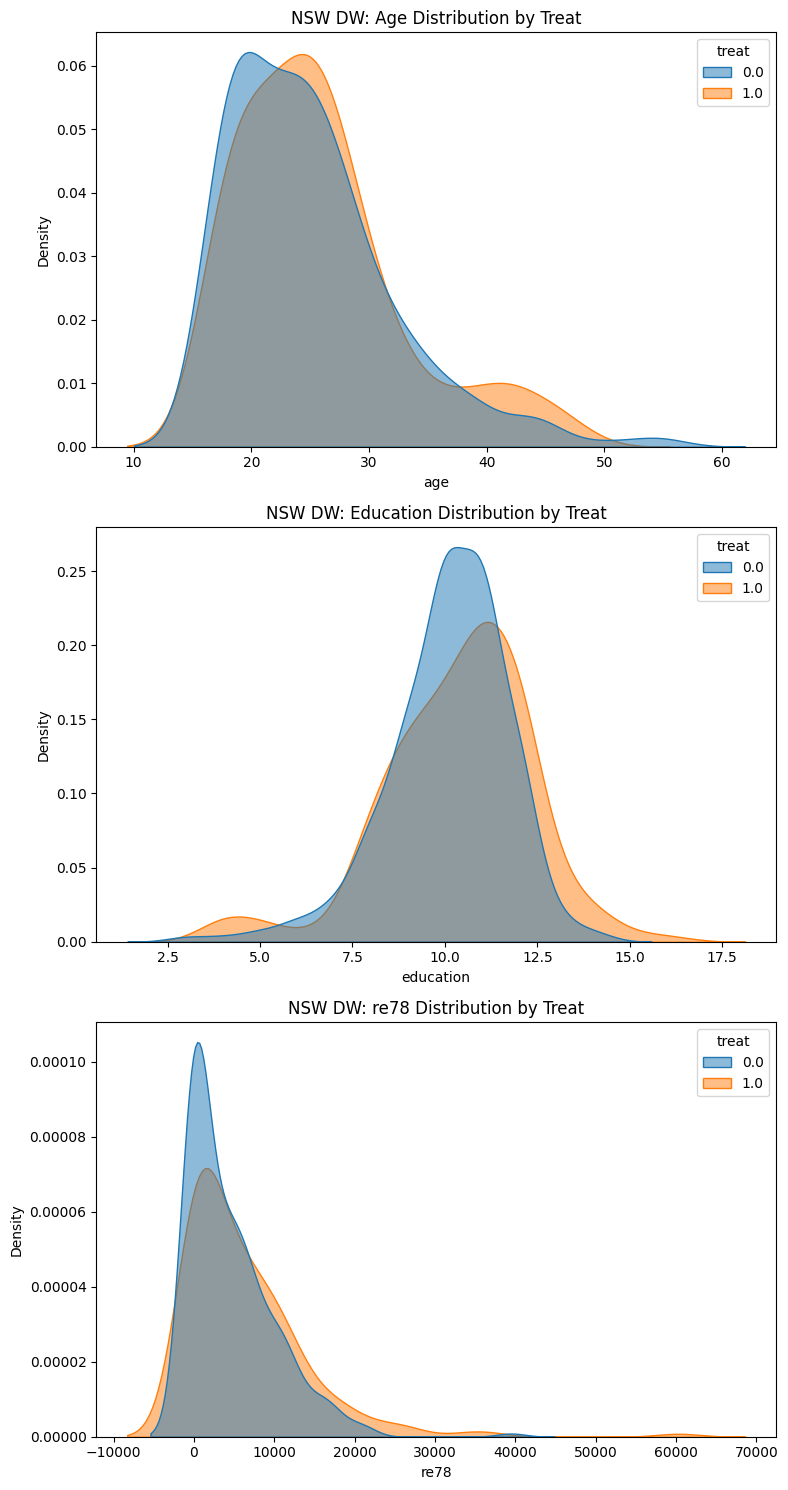

<ipython-input-7-65ec4a104447>:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=cps1_nsw_data, x='age', hue='treat', shade=True, alpha=0.5, ax=axes[0], common_norm=False)
<ipython-input-7-65ec4a104447>:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=cps1_nsw_data, x='education', hue='treat', shade=True, alpha=0.5, ax=axes[1], common_norm=False)
<ipython-input-7-65ec4a104447>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=cps1_nsw_data, x='re78', hue='treat', shade=True, alpha=0.5, ax=axes[2], common_norm=False)


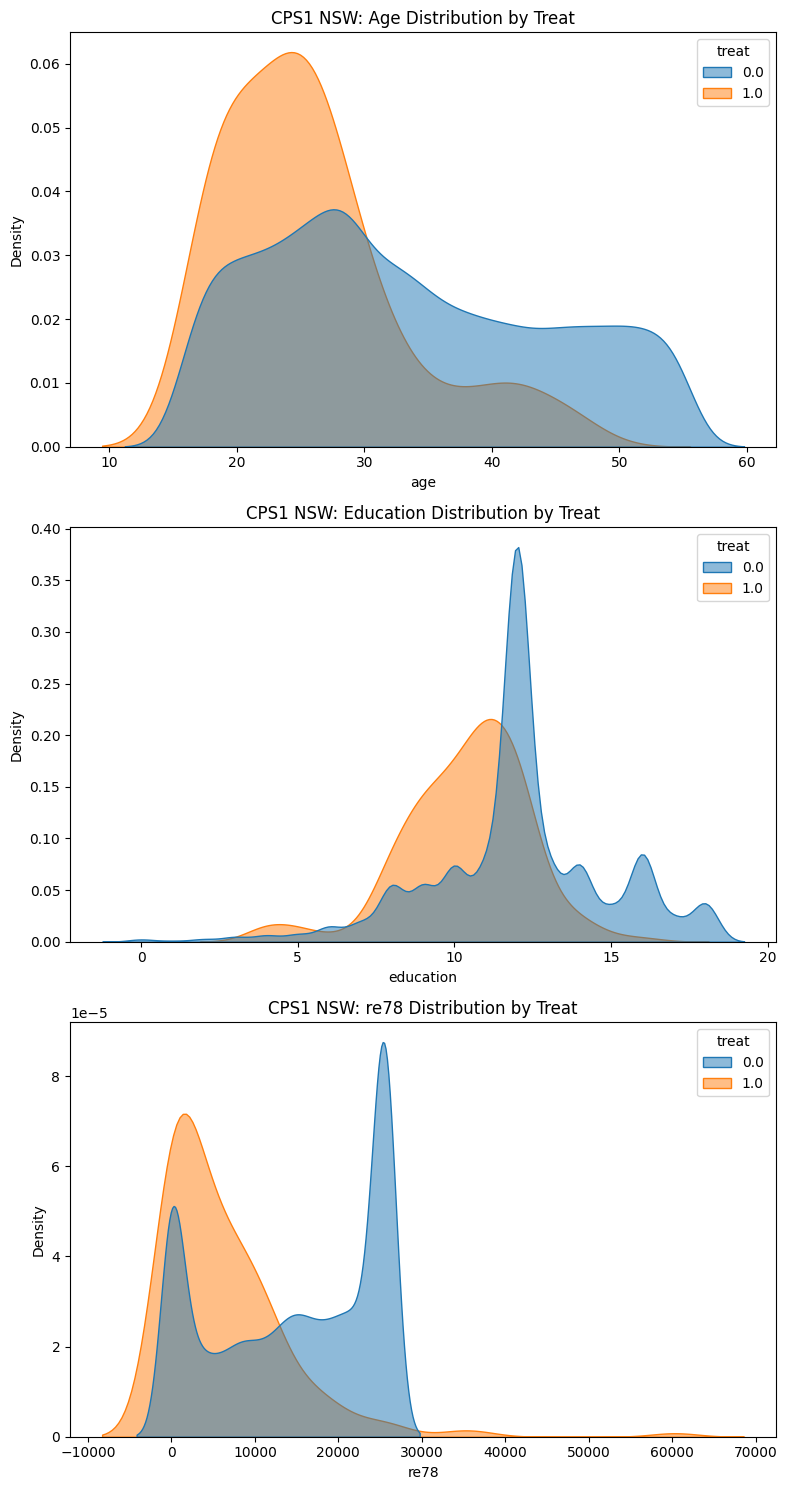

In [ ]:
# nswdw_data に対する描画を縦方向に並べる
fig, axes = plt.subplots(3, 1, figsize=(8, 15))  # 3行1列で縦に並べる
sns.kdeplot(data=nswdw_data, x='age', hue='treat', shade=True, alpha=0.5, ax=axes[0], common_norm=False)
axes[0].set_title('NSW DW: Age Distribution by Treat')

sns.kdeplot(data=nswdw_data, x='education', hue='treat', shade=True, alpha=0.5, ax=axes[1], common_norm=False)
axes[1].set_title('NSW DW: Education Distribution by Treat')

sns.kdeplot(data=nswdw_data, x='re78', hue='treat', shade=True, alpha=0.5, ax=axes[2], common_norm=False)
axes[2].set_title('NSW DW: re78 Distribution by Treat')

plt.tight_layout()
plt.show()

# cps1_nsw_data に対する描画を縦方向に並べる
fig, axes = plt.subplots(3, 1, figsize=(8, 15))  # 同様に3行1列
sns.kdeplot(data=cps1_nsw_data, x='age', hue='treat', shade=True, alpha=0.5, ax=axes[0], common_norm=False)
axes[0].set_title('CPS1 NSW: Age Distribution by Treat')

sns.kdeplot(data=cps1_nsw_data, x='education', hue='treat', shade=True, alpha=0.5, ax=axes[1], common_norm=False)
axes[1].set_title('CPS1 NSW: Education Distribution by Treat')

sns.kdeplot(data=cps1_nsw_data, x='re78', hue='treat', shade=True, alpha=0.5, ax=axes[2], common_norm=False)
axes[2].set_title('CPS1 NSW: re78 Distribution by Treat')

plt.tight_layout()
plt.show()


### NSWデータの分析

In [ ]:
# ナイーブな推定: グループ間の平均の比較
def naive_estimate(df, outcome, treatment='treat'):
    mean_treat = df[df[treatment] == 1][outcome].mean()
    mean_control = df[df[treatment] == 0][outcome].mean()
    tau = mean_treat - mean_control
    print(f"ナイーブな推定効果: {tau}")
    return tau

# 回帰分析関数の定義
def regression_analysis(df, formula, description="Regression"):
    model = smf.ols(formula=formula, data=df).fit()
    print(f"【{description}の回帰結果】")
    print(model.summary())
    return model

# 共変量（formula指定）
covariates = 'treat + age + black + hispanic + married + nodegree + education + re74 + re75'

In [ ]:
print("nswdw_dataのナイーブな推定効果:")
naive_estimate(nswdw_data, 're78')

# 共変量なしの回帰分析 (nswdw_data)
print("\n共変量なしの回帰分析 (nswdw_data):")
nsw_nocov_model = regression_analysis(nswdw_data, 're78 ~ treat', "nsw_nocov")

# 共変量ありの回帰分析 (nswdw_data)
print("\n共変量ありの回帰分析 (nswdw_data):")
nsw_cov_model = regression_analysis(nswdw_data, f're78 ~ {covariates}', "nsw_cov")


nswdw_dataのナイーブな推定効果:
ナイーブな推定効果: 1794.34326171875

共変量なしの回帰分析 (nswdw_data):
【nsw_nocovの回帰結果】
                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     8.039
Date:                Tue, 10 Dec 2024   Prob (F-statistic):            0.00479
Time:                        11:48:08   Log-Likelihood:                -4542.7
No. Observations:                 445   AIC:                             9089.
Df Residuals:                     443   BIC:                             9098.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

## CPS1データの分析：ナイーブな推定と回帰分析

In [ ]:
print("nswdw_dataのナイーブな推定効果:")
naive_estimate(cps1_nsw_data, 're78')

# cps1_nsw_dataの回帰分析
# 共変量（formula指定
covariates = 'treat + age + black + hispanic + married + nodegree + education + re74 + re75'

print("\ncps1_nsw_dataの共変量なし回帰分析:")
cps1_reg_model = regression_analysis(cps1_nsw_data, f're78 ~ treat', "cps1_reg")
print("\ncps1_nsw_dataの共変量あり回帰分析:")
cps1_reg_co_model = regression_analysis(cps1_nsw_data, f're78 ~ {covariates}', "cps1_co_reg")

nswdw_dataのナイーブな推定効果:
ナイーブな推定効果: -8497.515625

cps1_nsw_dataの共変量なし回帰分析:
【cps1_regの回帰結果】
                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     142.4
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           1.07e-32
Time:                        11:48:08   Log-Likelihood:            -1.7134e+05
No. Observations:               16177   AIC:                         3.427e+05
Df Residuals:                   16175   BIC:                         3.427e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

### 傾向スコアの分布

In [ ]:
# 傾向スコアの算出関数
def compute_ps(df, covariates, treatment='treat'):
    X = df[covariates]
    y = df[treatment]
    model = LogisticRegression(solver='lbfgs', max_iter=10000) # solver:{'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, default='lbfgs'
    model.fit(X, y)
    ps = model.predict_proba(X)[:,1]
    df['ps'] = ps
    # print("Propensity Scoreの算出が完了しました。")
    return model

# ヒストグラムの描画関数
def plot_ps_distribution(df, title):
    plt.figure(figsize=(10,6))
    sns.histplot(data=df, x='ps', hue='treat', multiple='layer', alpha=0.6, binwidth=0.05)
    plt.yscale('log')
    plt.title(title, fontsize=20)
    plt.xlabel('Propensity Score')
    plt.ylabel('Count')
    plt.show()


cps1_nsw_dataの傾向スコアの算出:

傾向スコアのヒストグラム (cps1_nsw_data):


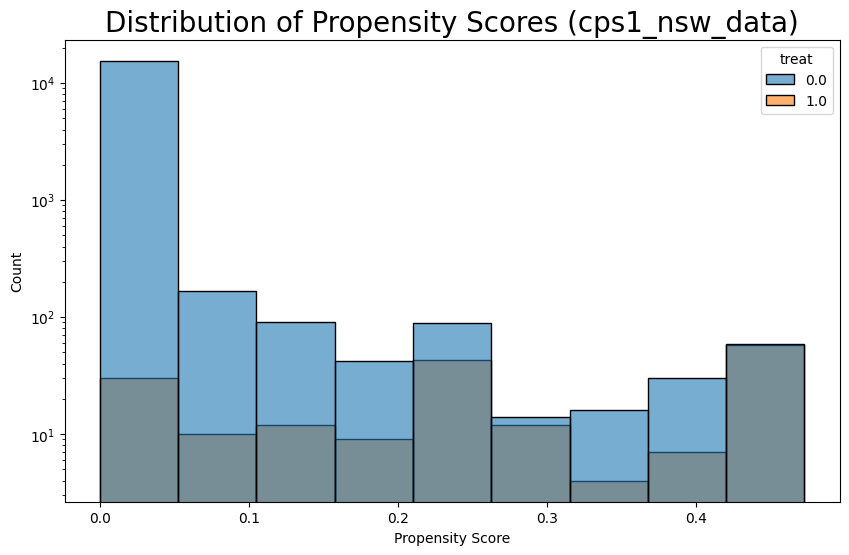

In [ ]:
# 傾向スコアの算出
# covariate_list = ['age', 'black', 'hispanic', 'married', 'nodegree', 'education', 're74', 're75', 're74_2', 're75_2']
covariate_list = ['age', 'black', 'hispanic', 'married', 'nodegree', 'education', 're74', 're75']
print("\ncps1_nsw_dataの傾向スコアの算出:")
ps_model_cps1 = compute_ps(cps1_nsw_data, covariate_list)

# 傾向スコアのヒストグラム
print("\n傾向スコアのヒストグラム (cps1_nsw_data):")
plot_ps_distribution(cps1_nsw_data, "Distribution of Propensity Scores (cps1_nsw_data)")

## CPS1データの分析：傾向スコアマッチング

In [ ]:
# 傾向スコアマッチング (Nearest Neighbor)
def propensity_score_matching(df, covariates, treatment='treat', method='nearest', caliper=0.2):
    matcher = NearestNeighborMatch(replace=False, ratio=1, caliper=caliper)
    matched = matcher.match(data=df, treatment_col=treatment, score_cols=['ps']) # 'ps' 列をスコアとして使用
    matched_df = matched[['re78', treatment] + covariates + ['ps']].dropna()
    print(f"Matching method: {method}, Caliper: {caliper}")
    return matched_df

In [ ]:
# マッチングの実行
print("\n傾向スコアマッチング (cps1_nsw_data):")
matched1_data = propensity_score_matching(cps1_nsw_data, covariate_list, method='nearest')


傾向スコアマッチング (cps1_nsw_data):
Matching method: nearest, Caliper: 0.2


In [ ]:
matched1_data

,re78,treat,age,black,hispanic,married,nodegree,education,re74,re75,ps
40,1254.582031,1.0,21.0,1.0,0.0,0.0,0.0,12.0,0.000000,0.000000,0.250218
66,0.000000,1.0,27.0,1.0,0.0,0.0,1.0,11.0,0.000000,0.000000,0.460252
47,0.000000,1.0,17.0,1.0,0.0,0.0,1.0,9.0,0.000000,0.000000,0.461362
35,20505.929688,1.0,42.0,1.0,0.0,0.0,0.0,14.0,0.000000,0.000000,0.239369
84,0.000000,1.0,27.0,1.0,0.0,0.0,1.0,8.0,0.000000,0.000000,0.443600
...,...,...,...,...,...,...,...,...,...,...,...
3055,0.000000,0.0,51.0,1.0,0.0,1.0,0.0,14.0,0.000000,0.000000,0.107024
15757,7673.833984,0.0,17.0,1.0,0.0,0.0,1.0,11.0,0.000000,0.000000,0.472518
15268,10784.450195,0.0,17.0,1.0,0.0,0.0,0.0,12.0,0.000000,449.371002,0.236275
11469,0.000000,0.0,29.0,1.0,0.0,0.0,0.0,15.0,525.083496,0.000000,0.252542


In [ ]:
# バランシングの評価 (標準化平均差の計算)
def standardized_mean_difference(df, covariates, treatment='treat', weights=None):
    smd = {}
    for cov in covariates:
        if weights is not None:
            treated = df[df[treatment]==1]
            control = df[df[treatment]==0]
            mean_treated = np.average(treated[cov], weights=treated[weights])
            mean_control = np.average(control[cov], weights=control[weights])
            var_treated = np.average((treated[cov]-mean_treated)**2, weights=treated[weights])
            var_control = np.average((control[cov]-mean_control)**2, weights=control[weights])
        else:
            treated = df[df[treatment]==1]
            control = df[df[treatment]==0]
            mean_treated = treated[cov].mean()
            mean_control = control[cov].mean()
            var_treated = treated[cov].var()
            var_control = control[cov].var()
        pooled_var = (var_treated + var_control) / 2
        smd[cov] = (mean_treated - mean_control) / np.sqrt(pooled_var)
    return smd


In [ ]:
# 標準化平均差の計算用の関数

# 連続値のカラムを計算
def numerical_asam(df, col_li, treatment="treat"):
    # 介入群と対照群に分ける
    treated_df = df[df[treatment]==1][col_li]
    control_df = df[df[treatment]==0][col_li]

    # 平均値
    treated_mean = treated_df.mean()
    control_mean = control_df.mean()

    # 不偏分散(標準偏差)
    treated_var = treated_df.var()
    control_var = control_df.var()

    # ASAMの計算
    numerical_asam_df = pd.DataFrame((treated_mean - control_mean) / np.sqrt((treated_var + control_var) / 2))
    numerical_asam_df.reset_index(inplace=True)
    numerical_asam_df.columns = ["Variable", "ASAM"]

    return numerical_asam_df

# カテゴリカルなデータを計算
def categorical_asam(df, col_li, treatment="treat"):
    results = []
    for col in col_li:
        # 各カテゴリの処置群と対照群の数を計算
        treated_cnt = len(df[(df[col] == 1) & (df['treat'] == 1)])
        control_cnt = len(df[(df[col] == 1) & (df['treat'] == 0)])

        # 全体のサンプルサイズ
        total_treated = len(df[df['treat'] == 1])
        total_control = len(df[df['treat'] == 0])

        # 各群におけるカテゴリの比率を計算
        treated_ratio = treated_cnt / total_treated if total_treated > 0 else 0
        control_ratio = control_cnt / total_control if total_control > 0 else 0

        # ASAMの計算
        asam = (treated_ratio - control_ratio) / np.sqrt((treated_ratio * (1 - treated_ratio) + control_ratio * (1 - control_ratio)) / 2)

        results.append({
            "Variable": col,
            "ASAM": asam
        })

    # リストをデータフレームに変換
    results_df = pd.DataFrame(results)

    return results_df

# 調整前後のデータのASAMを計算し、整形
def get_asam_df(before_df, after_df, numerical_col_li, categorical_col_li):
    before_numerical_asam = numerical_asam(before_df, numerical_col_li)
    before_categorical_asam = categorical_asam(before_df, categorical_col_li)

    after_numerical_asam = numerical_asam(after_df, numerical_col_li)
    after_categorical_asam = categorical_asam(after_df, categorical_col_li)

    before_asam_df = pd.concat([before_numerical_asam, before_categorical_asam], axis=0)
    after_asam_df = pd.concat([after_numerical_asam, after_categorical_asam], axis=0)

    asam_df = pd.merge(before_asam_df, after_asam_df, on="Variable", suffixes=("_before", "_after"))

    asam_df.reset_index(drop=True, inplace=True)

    return asam_df

In [ ]:
# 標準化平均差を計算
# numerical_col_li = ['age', 'education', 're74', 're75', 're74_2', 're75_2']
numerical_col_li = ['age', 'education', 're74', 're75']
categorical_col_li =['black', 'hispanic', 'married', 'nodegree']
psmatching_asam_df = get_asam_df(cps1_nsw_data, matched1_data, numerical_col_li, categorical_col_li)

,Variable,ASAM_before,ASAM_after
0,age,-0.796185,0.171477
1,education,-0.678514,-0.177323
2,re74,-1.568975,0.081598
3,re75,-1.746430,0.136449
4,black,2.432122,0.000000
5,hispanic,-0.050761,0.162758
6,married,-1.234102,0.014163
7,nodegree,0.905048,0.142374


<Figure size 1200x600 with 0 Axes>

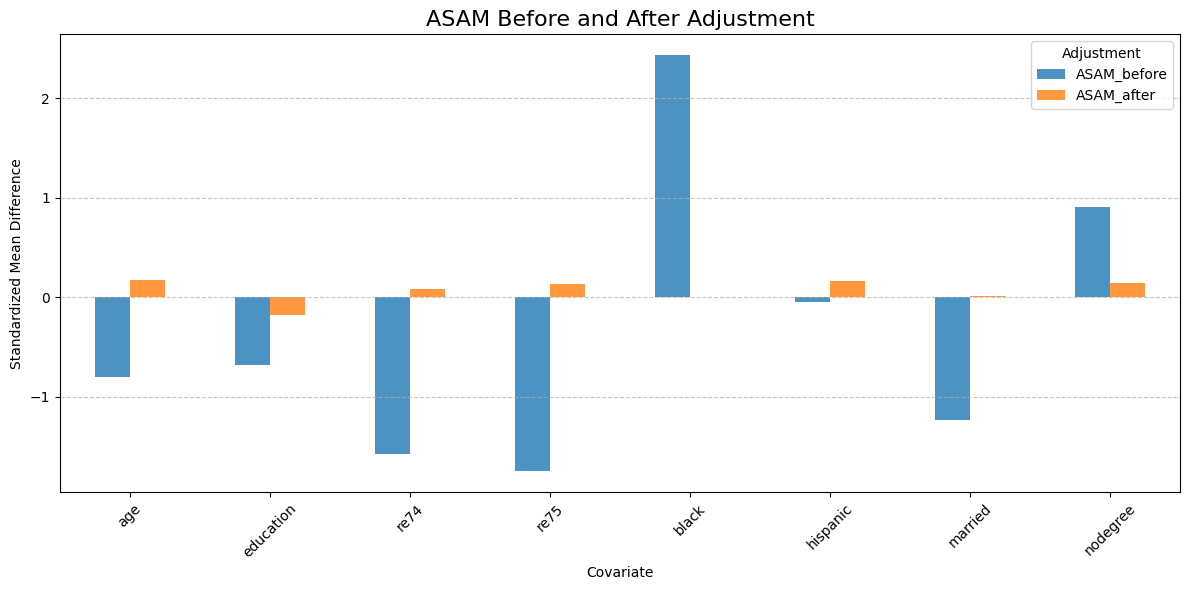

In [ ]:
display(psmatching_asam_df)

# グラフの描画
plt.figure(figsize=(12, 6))
psmatching_asam_df.plot(
    x="Variable",
    y=["ASAM_before", "ASAM_after"],
    kind="bar",
    figsize=(12, 6),
    alpha=0.8
)

# グラフの設定
plt.title("ASAM Before and After Adjustment", fontsize=16)
plt.ylabel("Standardized Mean Difference")
plt.xlabel("Covariate")
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Adjustment", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# グラフの表示
plt.show()


In [ ]:
# 効果推定 (マッチング後)
print("ナイーブな効果推定 (matched1_data):")
matched_re78_1 = matched1_data[matched1_data["treat"]==1]["re78"].mean()
matched_re78_0 = matched1_data[matched1_data["treat"]==0]["re78"].mean()
print(matched_re78_1)
print(matched_re78_0)
print(matched_re78_1 - matched_re78_0)
print("共変量無し回帰分析で効果推定 (matched1_data):")
psm1_noco_model = regression_analysis(matched1_data, f're78 ~ treat', "psm1_noco")
print("共変量有り回帰分析で効果推定 (matched1_data):")
psm1_co_model = regression_analysis(matched1_data, f're78 ~ {covariates}', "psm1_co")

ナイーブな効果推定 (matched1_data):
6487.7207
4717.093
1770.6279
共変量無し回帰分析で効果推定 (matched1_data):
【psm1_nocoの回帰結果】
                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     5.794
Date:                Tue, 10 Dec 2024   Prob (F-statistic):             0.0166
Time:                        11:48:19   Log-Likelihood:                -3674.5
No. Observations:                 358   AIC:                             7353.
Df Residuals:                     356   BIC:                             7361.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------


傾向スコアのヒストグラム (cps1_nsw_data):


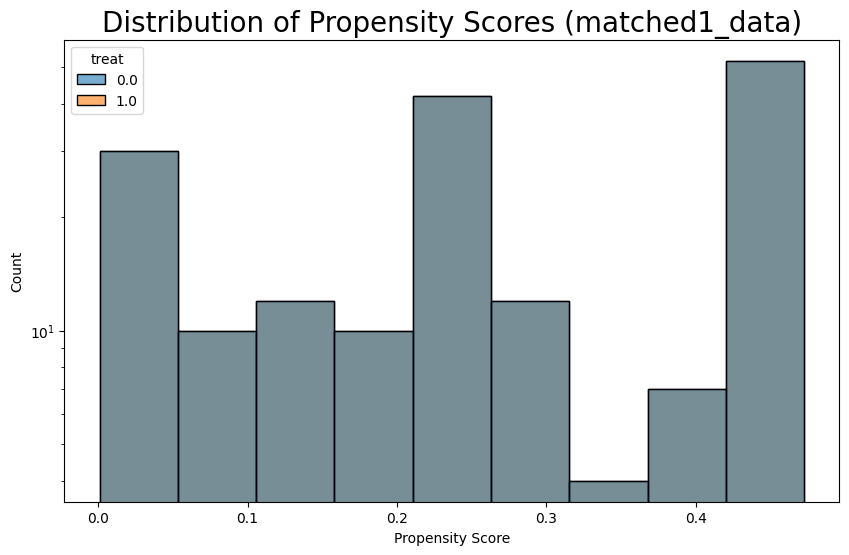

In [ ]:
# 傾向スコアのヒストグラム
print("\n傾向スコアのヒストグラム (cps1_nsw_data):")
plot_ps_distribution(matched1_data, "Distribution of Propensity Scores (matched1_data)")

## CPS1データの分析：IPW

### ATEの推定

In [ ]:
def get_ipw(X, y, random_state=0):
    # 傾向スコアを計算する
    ps_model = LogisticRegression(solver='lbfgs', random_state=random_state, max_iter=10000).fit(X, y)
    ps_score = ps_model.predict_proba(X)[:, 1]
    all_df = pd.DataFrame({'treatment': y, 'ps_score': ps_score})
    treatments = all_df.treatment.unique()
    if len(treatments) != 2:
        print('2群のマッチングしかできません。2群は必ず[0, 1]で表現してください。')
        raise ValueError
    # treatment == 1をgroup1, treatment == 0をgroup2とする。
    group1_df = all_df[all_df.treatment==1].copy()
    group2_df = all_df[all_df.treatment==0].copy()
    group1_df['weight'] = 1 / group1_df.ps_score
    group2_df['weight'] = 1 / (1 - group2_df.ps_score)
    weights = pd.concat([group1_df, group2_df]).sort_index()['weight'].values
    return weights

In [ ]:
# X = cps1_nsw_data[['age', 'education', 'black', 'hispanic', 'nodegree', 'married', 're74', 're75', 're74_2', 're75_2']]
X = cps1_nsw_data[['age', 'education', 'black', 'hispanic', 'nodegree', 'married', 're74', 're75']]
y = cps1_nsw_data['treat']
weights = get_ipw(X, y)

In [ ]:
cps1_nsw_data["weight_100"] = weights*100
cps1_nsw_data_expanded = cps1_nsw_data.loc[cps1_nsw_data.index.repeat(cps1_nsw_data['weight_100'])].reset_index(drop=True)
cps1_nsw_data_expanded

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78,ps,weight_100
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.045898,0.244231,417.924893
1,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.045898,0.244231,417.924893
2,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.045898,0.244231,417.924893
3,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.045898,0.244231,417.924893
4,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.045898,0.244231,417.924893
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2340127,CPS1,0.0,40.0,10.0,0.0,0.0,0.0,1.0,13628.660156,13144.549805,7979.724121,0.000654,100.064960
2340128,CPS1,0.0,40.0,10.0,0.0,0.0,0.0,1.0,13628.660156,13144.549805,7979.724121,0.000654,100.064960
2340129,CPS1,0.0,40.0,10.0,0.0,0.0,0.0,1.0,13628.660156,13144.549805,7979.724121,0.000654,100.064960
2340130,CPS1,0.0,40.0,10.0,0.0,0.0,0.0,1.0,13628.660156,13144.549805,7979.724121,0.000654,100.064960


In [ ]:
# 標準化平均差を計算
numerical_col_li = ['age', 'education', 're74', 're75']
categorical_col_li =['black', 'hispanic', 'married', 'nodegree']
ipw_asam_df = get_asam_df(cps1_nsw_data, cps1_nsw_data_expanded, numerical_col_li, categorical_col_li)

,Variable,ASAM_before,ASAM_after
0,age,-0.796185,-0.683856
1,education,-0.678514,-0.289856
2,re74,-1.568975,-0.815271
3,re75,-1.746430,-0.700846
4,black,2.432122,0.622805
5,hispanic,-0.050761,0.185945
6,married,-1.234102,-0.407361
7,nodegree,0.905048,0.237056


<Figure size 1200x600 with 0 Axes>

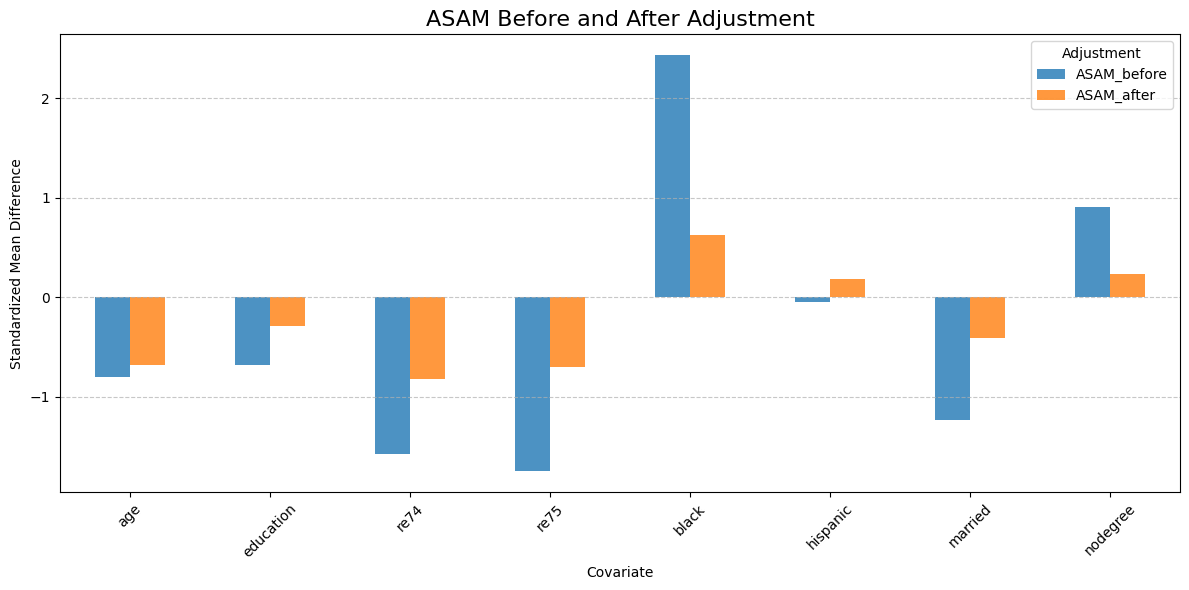

In [ ]:
display(ipw_asam_df)

# グラフの描画
plt.figure(figsize=(12, 6))
ipw_asam_df.plot(
    x="Variable",
    y=["ASAM_before", "ASAM_after"],
    kind="bar",
    figsize=(12, 6),
    alpha=0.8
)

# グラフの設定
plt.title("ASAM Before and After Adjustment", fontsize=16)
plt.ylabel("Standardized Mean Difference")
plt.xlabel("Covariate")
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Adjustment", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# グラフの表示
plt.show()

In [ ]:
# Yへの重み付きの平均差で算出
N = len(cps1_nsw_data)
D = cps1_nsw_data["treat"]
Y = cps1_nsw_data["re78"]
e_X = cps1_nsw_data["ps"]

# E[Y_1], E[Y_0]の推定
E_Y1 = np.sum(D * Y / e_X) / np.sum(D / e_X)
E_Y0 = np.sum((1 - D) * Y / (1 - e_X)) / np.sum((1 - D) / (1 - e_X))

# ATEの算出
ATE = E_Y1 - E_Y0

print(E_Y1)
print(E_Y0)
print(ATE)

8321.795288493402
14737.950768205665
-6416.155479712263


In [ ]:
## 重み付きデータでの効果の推定
y = cps1_nsw_data["re78"]

print("共変量無し回帰分析で効果推定 (matched1_data):")
X = cps1_nsw_data[['treat']]
X = sm.add_constant(X)
model = sm.WLS(y, X, weights=weights).fit()
results = model.summary()
print(results)

print("共変量有り回帰分析で効果推定 (matched1_data):")
coX = cps1_nsw_data[['treat', 'age', 'education', 'black', 'hispanic', 'nodegree', 'married', 're74', 're75']]
coX = sm.add_constant(coX)
co_model = sm.WLS(y, coX, weights=weights).fit()
co_results = co_model.summary()
print(co_results)

共変量無し回帰分析で効果推定 (matched1_data):
                            WLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.098
Model:                            WLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     1758.
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:48:34   Log-Likelihood:            -1.7303e+05
No. Observations:               16177   AIC:                         3.461e+05
Df Residuals:                   16175   BIC:                         3.461e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.474e+0

### ATTの推定

In [ ]:
def get_ipw_att(X, y, random_state=0):
    # 傾向スコアを計算する
    ps_model = LogisticRegression(solver='lbfgs', random_state=random_state, max_iter=10000).fit(X, y)
    ps_score = ps_model.predict_proba(X)[:, 1]
    all_df = pd.DataFrame({'treatment': y, 'ps_score': ps_score})
    treatments = all_df.treatment.unique()
    if len(treatments) != 2:
        print('2群のマッチングしかできません。2群は必ず[0, 1]で表現してください。')
        raise ValueError

    # treatment == 1をgroup1, treatment == 0をgroup2とする。
    group1_df = all_df[all_df.treatment==1].copy()
    group2_df = all_df[all_df.treatment==0].copy()


    # ATT: 介入群=1、対照群=ps/(1 - ps)
    group1_df['weight'] = 1
    group2_df['weight'] = group2_df.ps_score / (1 - group2_df.ps_score)

    weights = pd.concat([group1_df, group2_df]).sort_index()['weight'].values
    return weights


In [ ]:
X = cps1_nsw_data[['age', 'education', 'black', 'hispanic', 'nodegree', 'married', 're74', 're75']]
y = cps1_nsw_data['treat']
weights = get_ipw_att(X, y)

In [ ]:
cps1_nsw_data["weight_100"] = weights*100
cps1_nsw_data_expanded = cps1_nsw_data.loc[cps1_nsw_data.index.repeat(cps1_nsw_data['weight_100'])].reset_index(drop=True)
cps1_nsw_data_expanded

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78,ps,weight_100
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.045898,0.244231,100.000000
1,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.045898,0.244231,100.000000
2,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.045898,0.244231,100.000000
3,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.045898,0.244231,100.000000
4,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.045898,0.244231,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34374,CPS1,0.0,22.0,12.0,1.0,0.0,0.0,0.0,3975.352051,6801.435059,2757.437988,0.065102,7.128662
34375,CPS1,0.0,22.0,12.0,1.0,0.0,0.0,0.0,3975.352051,6801.435059,2757.437988,0.065102,7.128662
34376,CPS1,0.0,22.0,12.0,1.0,0.0,0.0,0.0,3975.352051,6801.435059,2757.437988,0.065102,7.128662
34377,CPS1,0.0,22.0,12.0,1.0,0.0,0.0,0.0,3975.352051,6801.435059,2757.437988,0.065102,7.128662


In [ ]:
# 標準化平均差を計算
numerical_col_li = ['age', 'education', 're74', 're75']
categorical_col_li =['black', 'hispanic', 'married', 'nodegree']
ipw_asam_df = get_asam_df(cps1_nsw_data, cps1_nsw_data_expanded, numerical_col_li, categorical_col_li)

,Variable,ASAM_before,ASAM_after
0,age,-0.796185,0.088862
1,education,-0.678514,0.075208
2,re74,-1.568975,0.050687
3,re75,-1.746430,0.088911
4,black,2.432122,-0.204717
5,hispanic,-0.050761,0.067007
6,married,-1.234102,0.069355
7,nodegree,0.905048,-0.062442


<Figure size 1200x600 with 0 Axes>

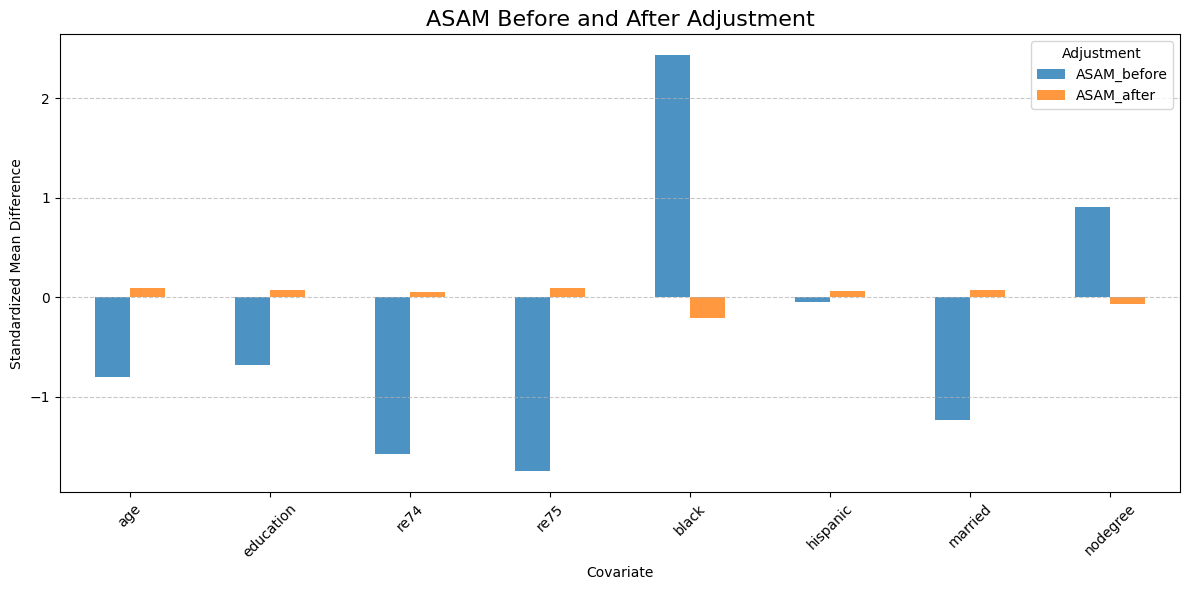

In [ ]:
display(ipw_asam_df)

# グラフの描画
plt.figure(figsize=(12, 6))
ipw_asam_df.plot(
    x="Variable",
    y=["ASAM_before", "ASAM_after"],
    kind="bar",
    figsize=(12, 6),
    alpha=0.8
)

# グラフの設定
plt.title("ASAM Before and After Adjustment", fontsize=16)
plt.ylabel("Standardized Mean Difference")
plt.xlabel("Covariate")
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Adjustment", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# グラフの表示
plt.show()

In [ ]:
# Yへの重み付きの平均差で算出
D = cps1_nsw_data["treat"]
Y = cps1_nsw_data["re78"]
e_X = cps1_nsw_data["ps"]

# E[Y_1], E[Y_0]の推定
E_Y1 = np.sum(D * Y ) / np.sum(D)
E_Y0 = np.sum((1 - D) * Y * e_X / (1 - e_X)) / np.sum((1 - D) * e_X / (1 - e_X))

# ATTの算出
ATT = E_Y1 - E_Y0

print(E_Y1)
print(E_Y0)
print(ATT)

6349.143
5195.630929678411
1153.5121367278389


In [ ]:
## 重み付きデータでの効果の推定
y = cps1_nsw_data["re78"]

print("共変量無し回帰分析で効果推定 (matched1_data):")
X = cps1_nsw_data[['treat']]
X = sm.add_constant(X)
model = sm.WLS(y, X, weights=weights).fit()
results = model.summary()
print(results)

print("共変量有り回帰分析で効果推定 (matched1_data):")
coX = cps1_nsw_data[['treat', 'age', 'education', 'black', 'hispanic', 'nodegree', 'married', 're74', 're75']]
coX = sm.add_constant(coX)
co_model = sm.WLS(y, coX, weights=weights).fit()
co_results = co_model.summary()
print(co_results)

共変量無し回帰分析で効果推定 (matched1_data):
                            WLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.007
Model:                            WLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     108.3
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           2.78e-25
Time:                        11:48:38   Log-Likelihood:            -2.0247e+05
No. Observations:               16177   AIC:                         4.049e+05
Df Residuals:                   16175   BIC:                         4.050e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5193.173